In [1]:
import pandas as pd
import os
import io
import re
from tqdm import tqdm
import pickle
import math

In [2]:
folder_directory = '/Users/leonard.lee/Downloads/CS5340_Project/moss'
file_name = '1821_1935_2023.csv'

moss_folder = os.path.join(folder_directory, file_name)

In [3]:
moss_data = pd.read_csv(moss_folder)

In [4]:
moss_data.sample(10)

,mission,cohort1,assessment1,submission1,name1,cohort2,assessment2,submission2,name2,percent1,percent2,lines,url
3936,rogue_train,1935,38693,1051933,daniel_shannon,2023,41917,1169200,joshua_butler,33,32,84,http://moss.stanford.edu/results/7/61832847082...
2250,2048_solver,1935,38688,1075006,timothy_tucker,2023,41914,1199764,timothy_tucker,99,99,126,http://moss.stanford.edu/results/5/88293824866...
2663,hungry_games_training_part_iii,1935,39738,1090829,christopher_mendoza,1935,39738,1087936,paula_guerrero,50,60,32,http://moss.stanford.edu/results/1/54197889831...
1402,book_of_advanced_spells,1935,38723,1028699,gloria_murray_dvm,1935,38723,1028548,shelly_craig,69,73,23,http://moss.stanford.edu/results/5/88376757115...
935,lazy_susan,1935,38724,1055876,janet_foster,1935,38724,1063696,raymond_west,52,51,32,http://moss.stanford.edu/results/0/56645335735...
826,curve_manipulation,1935,38727,1041577,rachel_wilson,2023,41898,1155937,holly_crane,55,58,37,http://moss.stanford.edu/results/6/28807170302...
1056,dna_translation,1935,39560,1081614,paula_guerrero,1935,39560,1086626,dominique_shaffer,91,84,80,http://moss.stanford.edu/results/5/39664034484...
3393,hungry_games_training_part_i,1821,33164,940979,sharon_ward,1821,33164,962624,adam_king,28,26,91,http://moss.stanford.edu/results/4/26835405649...
3146,rune_reading,1935,38701,1012264,jessica_smith,1935,38701,1014575,jorge_krause,95,95,28,http://moss.stanford.edu/results/8/89744940683...
2275,2048_solver,1821,33186,925371,marcus_moore,1935,38688,1079660,jamie_bennett,44,18,8,http://moss.stanford.edu/results/5/88293824866...


In [5]:
moss_data.shape

(4134, 13)

In [6]:
## Name to dict

all_names = set(moss_data.name1.tolist() + moss_data.name2.tolist())
name_to_ID = {name: i for i, name in enumerate(sorted(all_names))}
ID_to_name = {i: name for i, name in enumerate(sorted(all_names))}
name_ID_dict = {'all_names': all_names, 'name_to_ID': name_to_ID, 'ID_to_name': ID_to_name}

In [7]:
len(name_to_ID), name_to_ID['john_cuevas_md'], ID_to_name[476] ## Sanity Check

(1032, 476, 'john_cuevas_md')

In [8]:
pickle.dump(name_ID_dict, open('name_id_dict.pkl', 'wb'))

In [9]:
## Task 1 (edges)

moss_data = moss_data[moss_data['name1'] != moss_data['name2']]

In [10]:
import torch

unsorted_pairs = [(rows.name1, rows.name2) for _, rows in moss_data.iterrows() if rows.name1 != rows.name2]
pairs = []
for pair in unsorted_pairs:
    a = (pair[0], pair[1])
    b = (pair[1], pair[0])
    if a in pairs or b in pairs:
        continue
    else:
        pairs.append(pair)

sorted_pairs = sorted(set(pairs), key=lambda x: (name_to_ID[x[0]], name_to_ID[x[1]]))
tmp_s = list(map(lambda x: name_to_ID[x[0]], sorted_pairs))
tmp_t = list(map(lambda x: name_to_ID[x[1]], sorted_pairs))
src = []
for i, j in zip(tmp_s, tmp_t):
    src.append(i)
    src.append(j)
tgt = []
for i, j in zip(tmp_s, tmp_t):
    tgt.append(j)
    tgt.append(i)
edge_index = torch.tensor([src, tgt], dtype=torch.long)

In [11]:
## Get file lengths

def get_file_length(file_path, template_path):
    student_file = [line.strip() for line in io.open(file_path, 'r', encoding='utf-8') if line.strip() != '']
    template_file = [line.strip() for line in io.open(template_path, 'r', encoding='utf-8') if line.strip() != '']
    unique_lines = set(student_file).difference(set(template_file))
    return len(unique_lines)

lengths_dict = {'1821': {}, '1935': {}, '2023': {}}

folder = '/Users/leonard.lee/Downloads/CS5340_Project/global_moss'
subfolders = moss_data['mission'].unique().tolist()
for path in tqdm(subfolders):
    jpath = os.path.join(folder, path)
    files = os.listdir(jpath)
    for file in files:
        if file.split('.')[0] in ['1821', '1935', '2023']:
            batch = file.split('.')[0]
            name = '.'.join(file.split('.')[3:-1])
            leng = get_file_length(os.path.join(jpath, file), os.path.join(folder, 'templates/{}.py'.format(path)))
            if path not in lengths_dict[batch]:
                lengths_dict[batch][path] = {}
            lengths_dict[batch][path][name] = leng

100%|██████████| 28/28 [00:04<00:00,  5.92it/s]


In [12]:
lengths_dict['1935']['dna_using_data_directed_programming']['nathaniel_hood']

42

In [13]:
## Standardise two percentages and extract rank

method_name = 'uniq_lines'

def standardise_method(name, percent1, percent2, offending_lines, names, batch, mission, leng_dic):
    if name == 'min':
        return min(percent1, percent2)
    elif name == 'max':
        return max(percent1, percent2)
    elif name == 'avg':
        return (percent1+percent2)/2
    elif name == 'uniq_lines':
        try:
            denom = min(leng_dic[str(batch[0])][mission][names[0]], leng_dic[str(batch[1])][mission][names[1]])
        except:
            print(batch, mission, names)
        return offending_lines/denom

moss_data['standardised1'] = moss_data.apply(
    lambda x: standardise_method(method_name, x['percent1'], x['percent2'], 
                                 x['lines'], (x['name1'], x['name2']), 
                                 (x['cohort1'], x['cohort2']), x['mission'],
                                 lengths_dict),
    axis=1
)

pattern = re.compile(r'(match[0-9]+).html') ## Pattern to extract ranks
moss_data['Moss Rank'] = moss_data['url'].apply(lambda x: int(pattern.search(x)[0][5:-5]))

(2023, 2023) dna_using_data_directed_programming ('crystal_montgomery', 'carmen_lopez')


UnboundLocalError: local variable 'denom' referenced before assignment

In [35]:
## Group and Rank by missions

grouped_moss_data = moss_data.groupby(["mission"])
mission_titles = grouped_moss_data['mission'].unique().index.tolist()
max_rank = dict(zip(grouped_moss_data['Moss Rank'].max().index, grouped_moss_data['Moss Rank'].max()))
mission_averages = grouped_moss_data['standardised1'].mean()
sorted_averages = sorted(zip(mission_averages.index, mission_averages), key=lambda x: x[1])
normalized_averages = dict(map(lambda x: (x[0], 1/x[1]), sorted_averages))

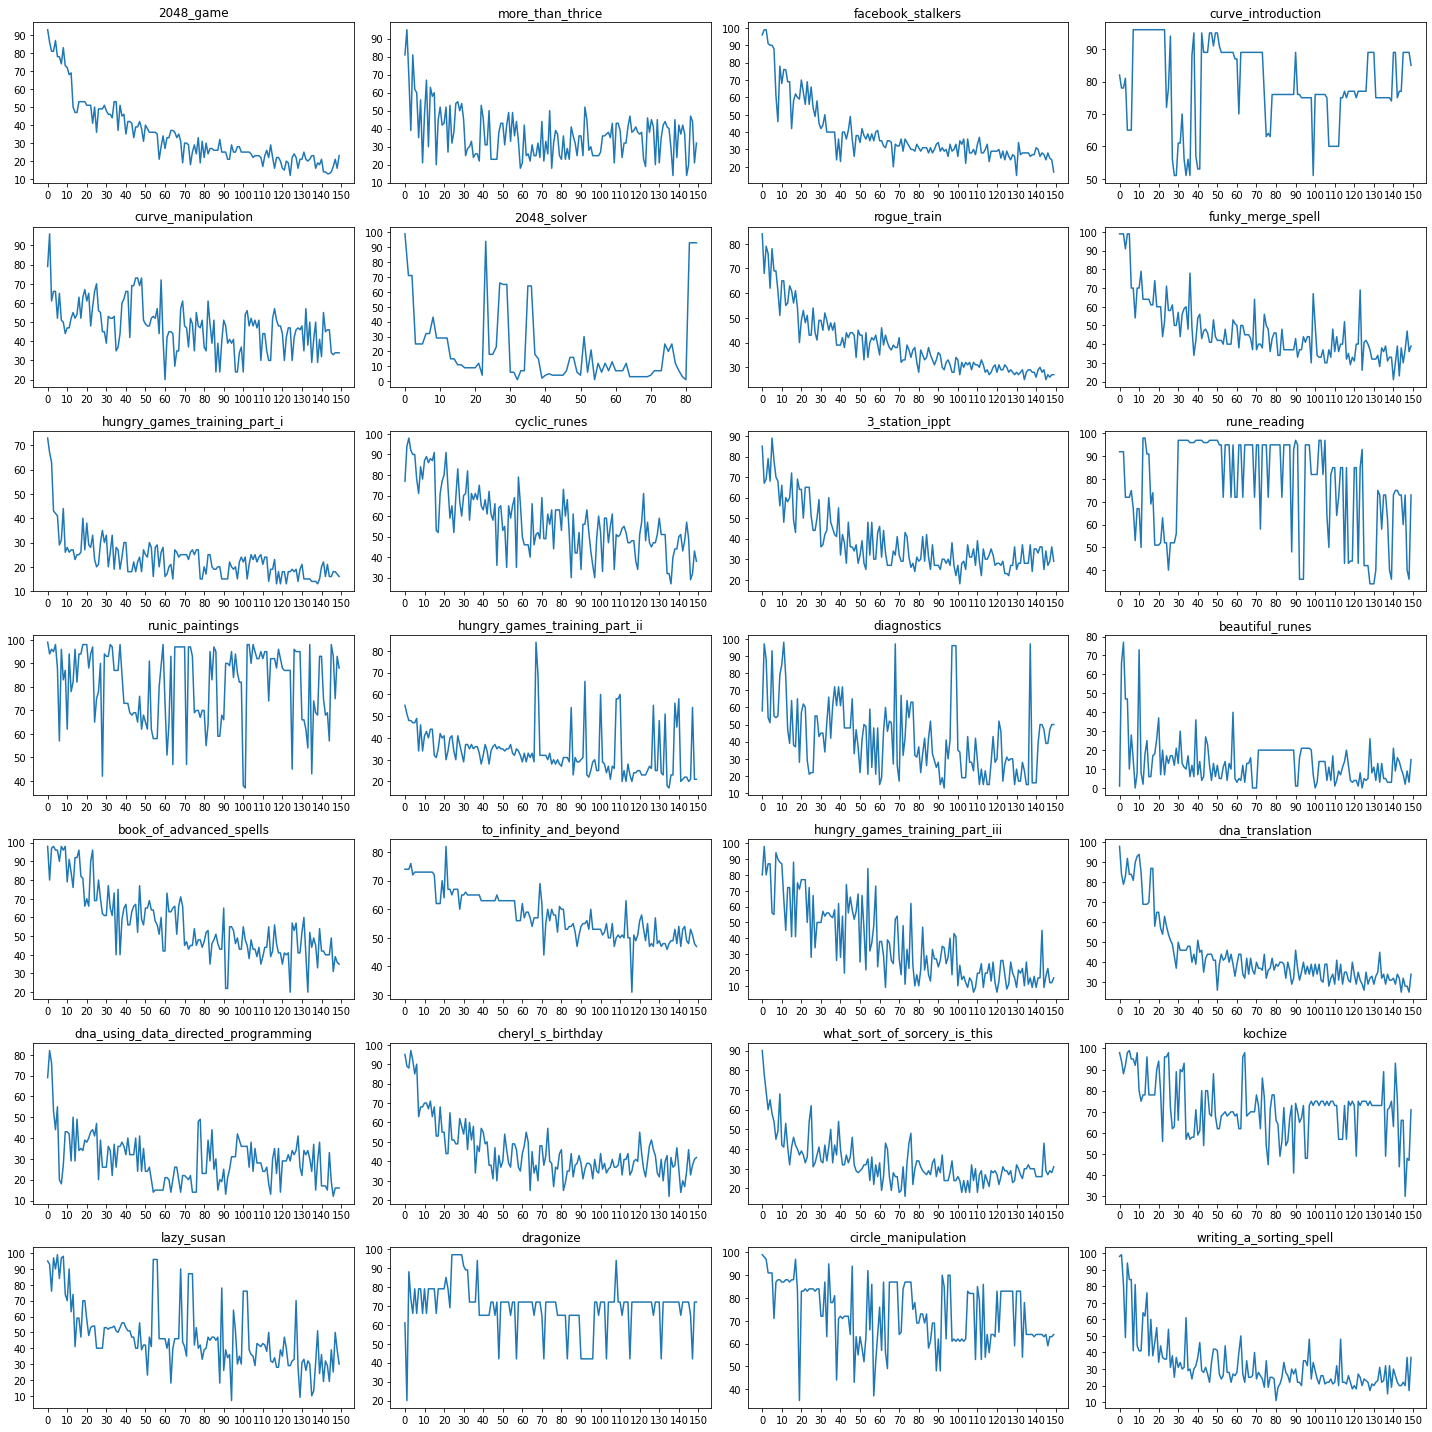

In [36]:
## Plot of Rank and Similarities

import numpy as np
import matplotlib.pyplot as plt

figure, ax = plt.subplots(nrows=7, ncols=4, figsize=[20, 20])
plt.setp(ax, xticks=[i for i in range(0, 151, 10)],
        yticks=[i for i in range(0, 101, 10)])
counter = 0
for name, group in grouped_moss_data:
    row, col = counter%7, counter%4
    x = np.array(group['Moss Rank'].tolist())
    y = np.array(group['standardised1'].tolist())
    ax[row, col].plot(x,y)
    ax[row, col].title.set_text('{}'.format(name))
    counter+=1
figure.tight_layout()

In [37]:
## Slice points by MOSS Rank

def points_aggregation(moss_rank, max_rank, points):
    return math.exp(-(moss_rank)/max_rank)*points

def obtain_points(moss_rank, mission, mrank, raverages):
    _max_rank = mrank[mission]
    points = raverages[mission]
    return points_aggregation(moss_rank, _max_rank, points)

moss_data['Points'] = moss_data.apply(lambda x: obtain_points(x['Moss Rank'], x['mission'], max_rank, normalized_averages), axis=1)

In [38]:
percentile_pairs = {}
for pairs in sorted_pairs:
    a = moss_data[(moss_data['name1'] == pairs[0]) & (moss_data['name2'] == pairs[1])]['Points'].sum()
    b = moss_data[(moss_data['name2'] == pairs[0]) & (moss_data['name1'] == pairs[1])]['Points'].sum()
    percentile_pairs[pairs] = a+b

In [39]:
# def normalizer(x, values):
#     maxx = max(values)
#     minn = min(values)
#     return (x-minn)/(maxx-minn)

# percentiles = dict(map(lambda x: (x[0], normalizer(x[1], percentile_pairs.values())), percentile_pairs.items()))

In [40]:
## Export from pandas to CSV

export_data = pd.DataFrame([], columns=['NodeID1', 'NodeID2', 'edge_weights'])
for pair in sorted_pairs:
    export_data=export_data.append({'NodeID1':pair[0], 'NodeID2':pair[1], 'edge_weights':percentile_pairs[pair]}, ignore_index=True)
    
export_data.to_csv('{}_edge_weights.csv'.format(method_name), index=False)

In [41]:
export_data.head()

,NodeID1,NodeID2,edge_weights
0,aaron_christian,joseph_trevino,0.008560
1,aaron_christian,marc_key,0.011331
2,aaron_pope,annette_solis,0.009494
3,aaron_pope,carol_harris,0.019015
4,aaron_powell,alicia_washington,0.061330


In [42]:
len(set(export_data.NodeID1.tolist() + export_data.NodeID2.tolist())), len(set(list(map(lambda x: x[0], sorted_pairs)) + list(map(lambda x: x[1], sorted_pairs))))

(1032, 1032)

In [62]:
folder_directory = '/Users/leonard.lee/Downloads/CS5340_Project/true_labels'
file_name = '2023.csv'
# file_name = '1935.csv'
# file_name = '1821.csv'

tl_folder = os.path.join(folder_directory, file_name)

In [63]:
tl_data = pd.read_csv(tl_folder)

In [64]:
tl_data

,Timestamp,Name,Please indicate your tutorial group,Please indicate the assignments,Indicate source,Is there anything else you would like us to know?
0,3/17/2021 22:35:08,jeff_hines,T32,"runic_painting,magic_efficiency,curve_introduc...",https://github.com/khoo0030/cs1010x\nhttps://g...,I guess I was just tempted to cheat cause of t...
1,3/17/2021 22:49:50,meagan_boyle,T34,"rogue_train,to_infinity_and_beyond",https://github.com/chunmun/CS1010S,"For mission 7, not all from the source but onl..."
2,3/17/2021 22:58:36,timothy_francis,T21,rogue_train,https://github.com/chunmun/CS1010S/blob/master...,NaN
3,3/17/2021 23:00:19,johnathan_velazquez,T35,"lazy_susan,3_station_ippt",https://stackoverflow.com/questions/49165175/p...,"For Lazy Susan Q5, I searched online to get so..."
4,3/17/2021 23:41:30,steven_campbell,T09,"curve_introduction,curve_manipulation,rogue_train",https://github.com/chunmun/CS1010S,NaN
5,3/18/2021 0:28:59,gary_brooks,T27,rogue_train,Janevy (This sem),I wish to emphasize that she did not send me h...
6,3/18/2021 2:59:19,harold_ryan,T23,"advanced_spells,kochize,dragonize","Chrus Chong, I believe he did this as IBLOC",NaN
7,3/18/2021 3:06:23,franklin_carlson,T33,"circle_manipulation,kochize,dragonize",Jun Jie Sem1,Couldnt visualize the code on Pythontutor so i...
8,3/18/2021 7:26:48,haley_patrick,T24,"rogue_train,3_station_ippt",https://github.com/chunmun/CS1010S,I sincerely apologise for cheating. It was dur...
9,3/18/2021 10:48:40,marc_key,T25,curve_manipulation,https://github.com/tanteidaiko/CS1010S-AY1819S...,There were 3 missions due that week so I had t...


In [65]:
## Task 2 & 3 (Check Moss Results)

def checker(name):
    if name in name_to_ID.keys():
        return name_to_ID[name]
    return 'Name Not Found Error'

labels = tl_data[['Name', 'Please indicate the assignments']]
labels['ID'] = labels['Name'].apply(lambda x: checker(x))
names_not_found = labels[labels['ID'] == 'Name Not Found Error']

/Users/leonard.lee/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [66]:
labels.head(n=30)

,Name,Please indicate the assignments,ID
0,jeff_hines,"runic_painting,magic_efficiency,curve_introduc...",411
1,meagan_boyle,"rogue_train,to_infinity_and_beyond",686
2,timothy_francis,rogue_train,978
3,johnathan_velazquez,"lazy_susan,3_station_ippt",485
4,steven_campbell,"curve_introduction,curve_manipulation,rogue_train",Name Not Found Error
5,gary_brooks,rogue_train,325
6,harold_ryan,"advanced_spells,kochize,dragonize",348
7,franklin_carlson,"circle_manipulation,kochize,dragonize",318
8,haley_patrick,"rogue_train,3_station_ippt",342
9,marc_key,curve_manipulation,644


In [67]:
names_not_found

,Name,Please indicate the assignments,ID
4,steven_campbell,"curve_introduction,curve_manipulation,rogue_train",Name Not Found Error
36,eric_ford,3_station_ippt,Name Not Found Error


In [68]:
names_not_found.to_csv('missing_names_'+file_name, index=False)

In [ ]:
## Task 4 (NetworkX)



In [11]:
## Task 5 (Edge_Index)

pattern = re.compile(r'(match[0-9]+).html')

edge_index = pd.DataFrame([], columns=['nodeid', 'mission', 'moss_ranking', 'edge_weights'])
for name in tqdm(all_names):
    idee = name_to_ID[name]
    relevant_rows = moss_data[(moss_data.name1 == name) | (moss_data.name2 == name)]
    for index, item in relevant_rows.iterrows():
        edge_index = edge_index.append({'nodeid': idee, 
                                        'mission': item.mission, 
                                        'moss_ranking': pattern.search(item.url)[0][5:-5], 
                                        }, ignore_index=True)

100%|██████████| 1032/1032 [00:25<00:00, 40.38it/s]


In [9]:
relevant_rows.head()

,mission,cohort1,assessment1,submission1,name1,cohort2,assessment2,submission2,name2,percent1,percent2,lines,url
510,funky_merge_spell,1821,33174,952434,morgan_williams,1935,38725,1059628,james_long,54,50,50,http://moss.stanford.edu/results/9/55540043683...
904,lazy_susan,1821,33173,951628,morgan_williams,2023,41931,1170102,jennifer_washington,91,90,103,http://moss.stanford.edu/results/0/56645335735...
909,lazy_susan,1821,33173,951628,morgan_williams,1935,38724,1048729,kenneth_allen,74,77,93,http://moss.stanford.edu/results/0/56645335735...
912,lazy_susan,1821,33173,951628,morgan_williams,1935,38724,1062843,corey_bender,63,69,92,http://moss.stanford.edu/results/0/56645335735...
916,lazy_susan,1821,33173,912554,michael_gomez,1821,33173,951628,morgan_williams,59,61,49,http://moss.stanford.edu/results/0/56645335735...


In [10]:
edge_index.head()

,NodeID,Mission,MOSS Ranking
0,822,dna_translation,11
1,822,dna_translation,67
2,822,dna_translation,126
3,822,what_sort_of_sorcery_is_this,116
4,822,kochize,10
